# Future Sales Prediction - Kaggle Competition

### Analysis File

https://www.kaggle.com/competitions/competitive-data-science-predict-future-sales/

#### File descriptions
- sales_train.csv - the training set. Daily historical data from January 2013 to October 2015.

- test.csv - the test set. You need to forecast the sales for these shops and products for November 2015.

- sample_submission.csv - a sample submission file in the correct format.

- items.csv - supplemental information about the items/products.

- item_categories.csv  - supplemental information about the items categories.

- shops.csv- supplemental information about the shops.

#### Data fields

- ID - an Id that represents a (Shop, Item) tuple within the test set

- shop_id - unique identifier of a shop

- item_id - unique identifier of a product

- item_category_id - unique identifier of item category

- item_cnt_day - number of products sold. You are predicting a monthly amount of this measure

- item_price - current price of an item

- date - date in format dd/mm/yyyy

- date_block_num - a consecutive month number, used for convenience. January 2013 is 0, February 2013 is 1,..., October 2015 is 33

- item_name - name of item

- shop_name - name of shop

- item_category_name - name of item category

### I. Import the dataset and data analysis libraries

In [89]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [90]:
sales_train = pd.read_csv("data/sales_train.csv")
sales_train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


In [91]:
test = pd.read_csv("data/test.csv")
test.head()

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


In [92]:
sample_submission = pd.read_csv("data/sample_submission.csv")
print(sample_submission.shape)
sample_submission.head()

(214200, 2)


,ID,item_cnt_month
0,0,0.5
1,1,0.5
2,2,0.5
3,3,0.5
4,4,0.5


In [93]:
items = pd.read_csv("data/items.csv")
items.head()

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40


In [94]:
item_categories = pd.read_csv("data/item_categories.csv")
item_categories.head()

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4


In [95]:
shops = pd.read_csv("data/shops.csv")
shops.head()

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4


### II. Initial data checks and manipulations

In [96]:
sales_train.shape

(2935849, 6)

In [97]:
sales_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 6 columns):
 #   Column          Dtype  
---  ------          -----  
 0   date            object 
 1   date_block_num  int64  
 2   shop_id         int64  
 3   item_id         int64  
 4   item_price      float64
 5   item_cnt_day    float64
dtypes: float64(2), int64(3), object(1)
memory usage: 134.4+ MB


Note that the ```date``` column is not in the proper datetime format.

In [98]:
sales_train['date'] = pd.to_datetime(sales_train['date'], format = '%d.%m.%Y')
sales_train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,2013-01-02,0,59,22154,999.00,1.0
1,2013-01-03,0,25,2552,899.00,1.0
2,2013-01-05,0,25,2552,899.00,-1.0
3,2013-01-06,0,25,2554,1709.05,1.0
4,2013-01-15,0,25,2555,1099.00,1.0


In [99]:
# Split into month, day, and year
sales_train['year'] = sales_train['date'].dt.year
sales_train['month'] = sales_train['date'].dt.month
sales_train['day'] = sales_train['date'].dt.day
sales_train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,year,month,day
0,2013-01-02,0,59,22154,999.00,1.0,2013,1,2
1,2013-01-03,0,25,2552,899.00,1.0,2013,1,3
2,2013-01-05,0,25,2552,899.00,-1.0,2013,1,5
3,2013-01-06,0,25,2554,1709.05,1.0,2013,1,6
4,2013-01-15,0,25,2555,1099.00,1.0,2013,1,15


In [100]:
# Keep the month-year pair (in string format) to make date_block_num column more intelligible
sales_train['month_year'] = sales_train['date'].dt.strftime('%Y-%m-%d').str[:7]

# dt.strftime(...) to convert the datetime format of 'date' into string format
# str[:7] to extract the month and year in the date string

sales_train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,year,month,day,month_year
0,2013-01-02,0,59,22154,999.00,1.0,2013,1,2,2013-01
1,2013-01-03,0,25,2552,899.00,1.0,2013,1,3,2013-01
2,2013-01-05,0,25,2552,899.00,-1.0,2013,1,5,2013-01
3,2013-01-06,0,25,2554,1709.05,1.0,2013,1,6,2013-01
4,2013-01-15,0,25,2555,1099.00,1.0,2013,1,15,2013-01


In [101]:
sales_train.isna().sum()

date              0
date_block_num    0
shop_id           0
item_id           0
item_price        0
item_cnt_day      0
year              0
month             0
day               0
month_year        0
dtype: int64

In [102]:
sales_train.nunique()

date               1034
date_block_num       34
shop_id              60
item_id           21807
item_price        19993
item_cnt_day        198
year                  3
month                12
day                  31
month_year           34
dtype: int64

In [103]:
# Describing datetime and quantitative variables
sales_train[['date', 'item_price', 'item_cnt_day']].describe()

,date,item_price,item_cnt_day
count,2935849,2.935849e+06,2.935849e+06
mean,2014-04-03 05:44:34.970681344,8.908532e+02,1.242641e+00
min,2013-01-01 00:00:00,-1.000000e+00,-2.200000e+01
25%,2013-08-01 00:00:00,2.490000e+02,1.000000e+00
50%,2014-03-04 00:00:00,3.990000e+02,1.000000e+00
75%,2014-12-05 00:00:00,9.990000e+02,1.000000e+00
max,2015-10-31 00:00:00,3.079800e+05,2.169000e+03
std,NaN,1.729800e+03,2.618834e+00


In [104]:
# Declaring categorical variables
sales_train['shop_id'] = pd.Categorical(sales_train['shop_id'])
sales_train['item_id'] = pd.Categorical(sales_train['item_id'])

In [105]:
# Describing categorical variables
sales_train[['month_year', 'shop_id', 'item_id']].describe()

,month_year,shop_id,item_id
count,2935849,2935849,2935849
unique,34,60,21807
top,2013-12,31,20949
freq,143246,235636,31340


In [106]:
print(f'Number of item_cnt_day values below 0: {sales_train[sales_train['item_cnt_day'] < 0].shape[0]}')

Number of item_cnt_day values below 0: 7356


In [107]:
# Convert negative to positive values in item_cnt_day
sales_train['item_cnt_day'] = sales_train['item_cnt_day'].abs()

In [108]:
# Create a "master table" for EDA in training data
sales_full = sales_train.merge(items, how = 'inner', on = 'item_id')\
                              .merge(item_categories, how = 'inner', on = 'item_category_id')\
                              .merge(shops, how = 'inner', on = 'shop_id')

sales_full.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,year,month,day,month_year,item_name,item_category_id,item_category_name,shop_name
0,2013-01-02,0,59,22154,999.00,1.0,2013,1,2,2013-01,ЯВЛЕНИЕ 2012 (BD),37,Кино - Blu-Ray,"Ярославль ТЦ ""Альтаир"""
1,2013-01-03,0,25,2552,899.00,1.0,2013,1,3,2013-01,DEEP PURPLE The House Of Blue Light LP,58,Музыка - Винил,"Москва ТРК ""Атриум"""
2,2013-01-05,0,25,2552,899.00,1.0,2013,1,5,2013-01,DEEP PURPLE The House Of Blue Light LP,58,Музыка - Винил,"Москва ТРК ""Атриум"""
3,2013-01-06,0,25,2554,1709.05,1.0,2013,1,6,2013-01,DEEP PURPLE Who Do You Think We Are LP,58,Музыка - Винил,"Москва ТРК ""Атриум"""
4,2013-01-15,0,25,2555,1099.00,1.0,2013,1,15,2013-01,DEEP PURPLE 30 Very Best Of 2CD (Фирм.),56,Музыка - CD фирменного производства,"Москва ТРК ""Атриум"""


### III. EDA for quantitative variables

#### Original distribution of the data:

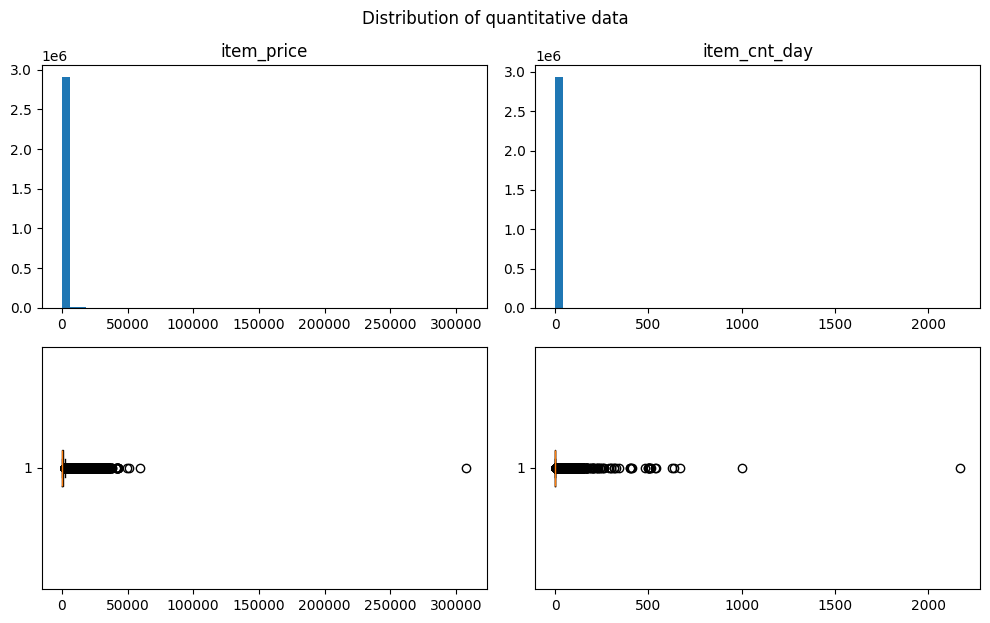

In [109]:
# Distribution of quantitative data
fig, ax = plt.subplots(nrows = 2, ncols = 2, figsize = (10, 6))
ax[0][0].hist(sales_full['item_price'], bins = 50)
ax[0][0].set_title('item_price')
ax[1][0].boxplot(sales_full['item_price'], vert = False)

ax[0][1].hist(sales_full['item_cnt_day'], bins = 50)
ax[0][1].set_title('item_cnt_day')
ax[1][1].boxplot(sales_full['item_cnt_day'], vert = False)

plt.tight_layout()
fig.suptitle('Distribution of quantitative data', y = 1.03)
plt.show()

In [110]:
# Correlation matrix for the quantitative variables
sales_full[['item_price', 'item_cnt_day']].corr()

,item_price,item_cnt_day
item_price,1.000000,0.011841
item_cnt_day,0.011841,1.000000


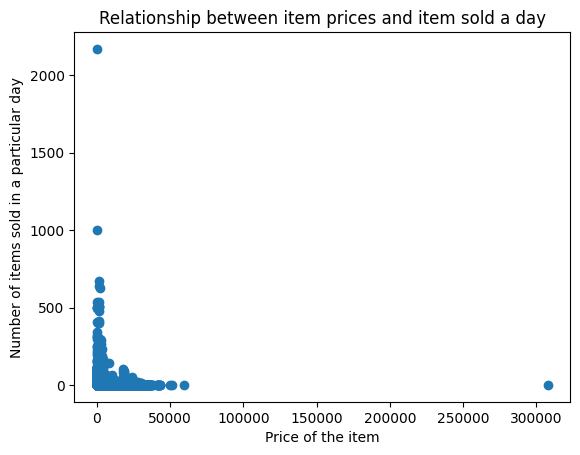

In [111]:
# Visualize the correlation
fig, ax = plt.subplots()
ax.scatter(sales_full['item_price'], sales_full['item_cnt_day'])

ax.set_title('Relationship between item prices and item sold a day')
ax.set_xlabel('Price of the item')
ax.set_ylabel('Number of items sold in a particular day')
plt.show()

#### Removing massive outliers:

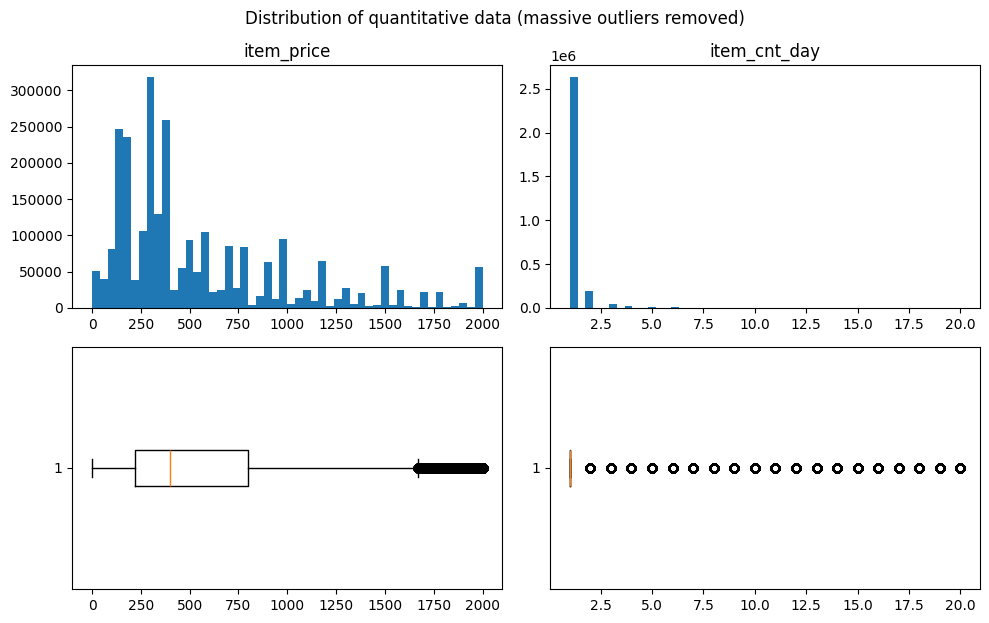

In [112]:
# Remove the outliers and see how the distribution changes
low_prices = sales_full[sales_full['item_price'] <= 2000]
low_cnt_day = sales_full[sales_full['item_cnt_day'] <= 20]

fig, ax = plt.subplots(nrows = 2, ncols = 2, figsize = (10, 6))
ax[0][0].hist(low_prices['item_price'], bins = 50)
ax[0][0].set_title('item_price')
ax[1][0].boxplot(low_prices['item_price'], vert = False)

ax[0][1].hist(low_cnt_day['item_cnt_day'], bins = 50)
ax[0][1].set_title('item_cnt_day')
ax[1][1].boxplot(low_cnt_day['item_cnt_day'], vert = False)

plt.tight_layout()
fig.suptitle('Distribution of quantitative data (massive outliers removed)', y = 1.03)
plt.show()

In [113]:
# Filter for items that had prices of <= 2000 AND item counts per day of <= 20.0
outliers_removed = sales_full[np.logical_and(sales_full['item_price'] <= 2000, sales_full['item_cnt_day'] <= 20)]

# Correlation matrix for the quantitative variables
outliers_removed[['item_price', 'item_cnt_day']].corr()

,item_price,item_cnt_day
item_price,1.000000,-0.007754
item_cnt_day,-0.007754,1.000000


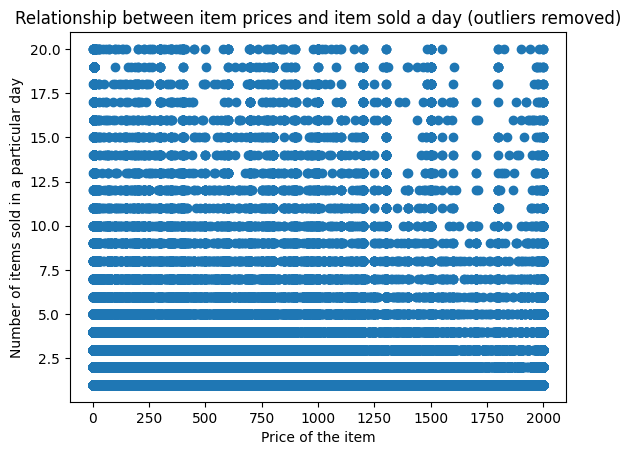

In [114]:
# Visualize the correlation
fig, ax = plt.subplots()
ax.scatter(outliers_removed['item_price'], outliers_removed['item_cnt_day'])

ax.set_title('Relationship between item prices and item sold a day (outliers removed)')
ax.set_xlabel('Price of the item')
ax.set_ylabel('Number of items sold in a particular day')
plt.show()

#### Grouping by month:

In [115]:
sales_full_trunc = sales_full[['month_year', 'item_id', 'item_price', 'item_cnt_day']]
sales_full_trunc = sales_full_trunc.groupby(['month_year', 'item_id', 'item_price'], as_index = False).sum()
sales_full_trunc.rename(columns = {'item_cnt_day': 'item_cnt_month'}, inplace = True)
sales_full_trunc.head()

,month_year,item_id,item_price,item_cnt_month
0,2013-01,19,28.0,1.0
1,2013-01,27,1890.0,2.0
2,2013-01,27,2499.0,5.0
3,2013-01,28,549.0,8.0
4,2013-01,29,1890.0,1.0


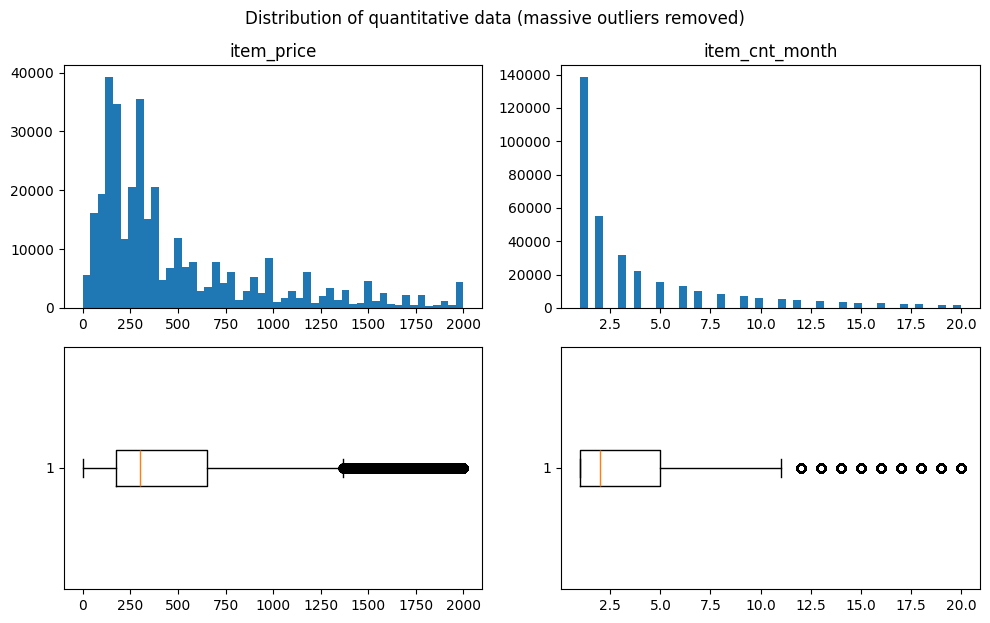

In [116]:
# Outliers removed
low_prices_trunc = sales_full_trunc[sales_full_trunc['item_price'] <= 2000]
low_cnt_month = sales_full_trunc[sales_full_trunc['item_cnt_month'] <= 20] # true target labels are clipped at [0, 20]

fig, ax = plt.subplots(nrows = 2, ncols = 2, figsize = (10, 6))
ax[0][0].hist(low_prices_trunc['item_price'], bins = 50)
ax[0][0].set_title('item_price')
ax[1][0].boxplot(low_prices_trunc['item_price'], vert = False)

ax[0][1].hist(low_cnt_month['item_cnt_month'], bins = 50)
ax[0][1].set_title('item_cnt_month')
ax[1][1].boxplot(low_cnt_month['item_cnt_month'], vert = False)

plt.tight_layout()
fig.suptitle('Distribution of quantitative data (massive outliers removed)', y = 1.03)
plt.show()

In [117]:
# Draw the same correlation matrix (with outliers removed) but grouped by month
outliers_removed_2 = sales_full_trunc[np.logical_and(sales_full_trunc['item_price'] <= 2000, sales_full_trunc['item_cnt_month'] <= 20)]

# Correlation matrix for the quantitative variables
outliers_removed_2[['item_price', 'item_cnt_month']].corr()

,item_price,item_cnt_month
item_price,1.00000,0.01767
item_cnt_month,0.01767,1.00000


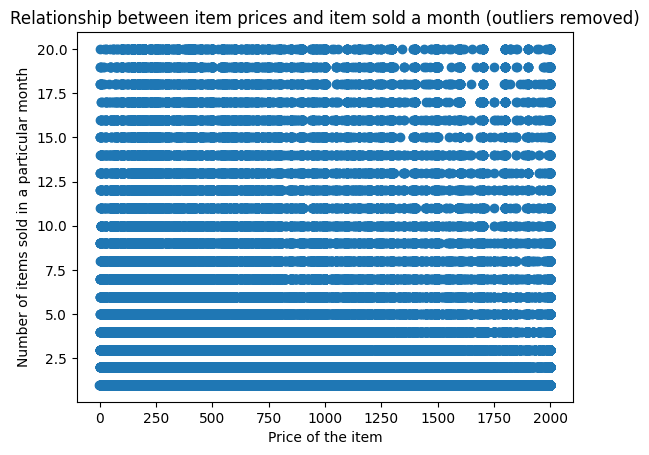

In [118]:
# Visualize the correlation
fig, ax = plt.subplots()
ax.scatter(outliers_removed_2['item_price'], outliers_removed_2['item_cnt_month'])

ax.set_title('Relationship between item prices and item sold a month (outliers removed)')
ax.set_xlabel('Price of the item')
ax.set_ylabel('Number of items sold in a particular month')
plt.show()

### IV. EDA for categorical variables

In [119]:
# Top 10 highest priced item (with names) during 2013-2015
highest_priced = sales_full[['item_id', 'item_name', 'item_price']].copy() # keep only necessary columns
highest_priced.drop_duplicates(subset = ['item_id'], inplace = True) # drop duplicates
highest_priced = highest_priced.sort_values('item_price', ascending = False).iloc[:10] # sort for top 10

highest_priced

,item_id,item_name,item_price
1163158,6066,Radmin 3 - 522 лиц.,307980.0
1488135,13199,Коллекционные шахматы (Властелин Колец),50999.0
2327159,7241,UserGate Proxy & Firewall 6.X с модулем фильтр...,49782.0
2885692,13403,"Комплект ""Microsoft Xbox One 1TB Limited Edit...",42990.0
1006638,7238,UserGate Proxy & Firewall 6.X до 100 сессий,42000.0
2143903,14173,Лицензия 1С-Битрикс: Управление сайтом - Эксперт,40900.0
884848,2410,CorelDRAW Graphics Suite X6 - Small Business E...,36990.0
2890662,13448,Комплект Sony PlayStation 4 (1Tb) Black (CUH-1...,34990.0
2907568,13503,Комплект «Sony PlayStation 4 (1Tb) Black (CUH-...,34990.0
2113,5748,Photoshop 13 Windows Russian BOX,32990.0


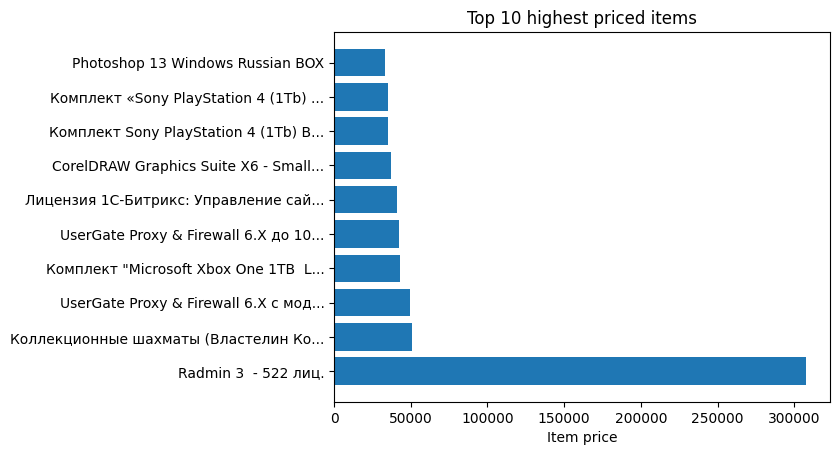

In [120]:
# Truncate item names to 35 characters because many of them are so long
highest_priced['item_name_trunc'] = highest_priced['item_name'].case_when([
    (highest_priced['item_name'].str.len() <= 35, highest_priced['item_name']),
    (highest_priced['item_name'].str.len() > 35, highest_priced['item_name'].str[:35] + "...")
])

fig, ax = plt.subplots()
ax.barh(highest_priced['item_name_trunc'], highest_priced['item_price'])

ax.set_xlabel('Item price')
ax.set_title('Top 10 highest priced items')
plt.show()

In [121]:
# Top 10 items with the most quantity sold
most_sold = sales_full[['item_id', 'item_name', 'item_cnt_day']].copy() # keep only necessary columns
most_sold = most_sold.groupby(['item_id', 'item_name']).sum()
most_sold = most_sold.sort_values('item_cnt_day', ascending = False).iloc[:10] # sort for top 10
most_sold.reset_index(inplace = True)

most_sold

,item_id,item_name,item_cnt_day
0,20949,Фирменный пакет майка 1С Интерес белый (34*42)...,187678.0
1,2808,"Diablo III [PC, Jewel, русская версия]",17265.0
2,3732,"Grand Theft Auto V [PS3, русские субтитры]",16710.0
3,17717,Прием денежных средств для 1С-Онлайн,15830.0
4,5822,Playstation Store пополнение бумажника: Карта ...,14529.0
5,3734,"Grand Theft Auto V [Xbox 360, русские субтитры]",11778.0
6,6675,Sony PlayStation 4 (500 Gb) Black (CUH-1008A/1...,10341.0
7,3731,"Grand Theft Auto V [PC, русские субтитры]",10111.0
8,1855,"Battlefield 4 [PC, русская версия]",10050.0
9,16787,"Одни из нас [PS3, русская версия]",9283.0


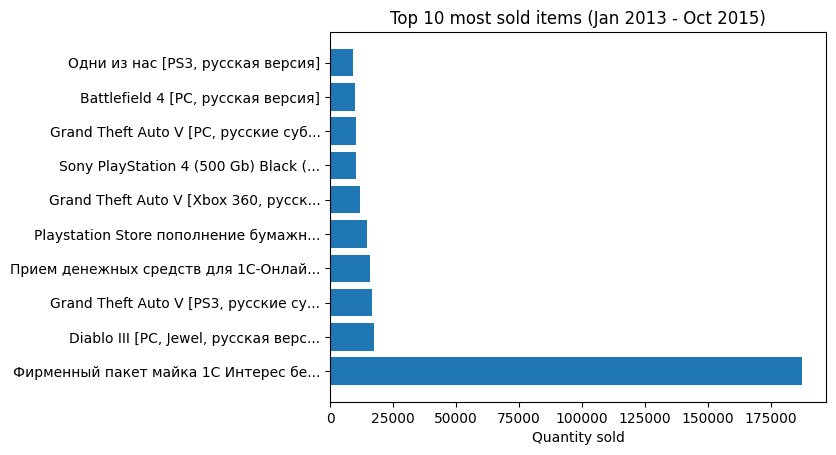

In [122]:
most_sold['item_name_trunc'] = most_sold['item_name'].case_when([
    (most_sold['item_name'].str.len() <= 35, most_sold['item_name']),
    (most_sold['item_name'].str.len() > 35, most_sold['item_name'].str[:35] + "...")
])

fig, ax = plt.subplots()
ax.barh(most_sold['item_name_trunc'], most_sold['item_cnt_day'])

ax.set_xlabel('Quantity sold')
ax.set_title('Top 10 most sold items (Jan 2013 - Oct 2015)')
plt.show()

In [123]:
print(f'Full name of the most sold item: {most_sold.iloc[0, 1]}')

Full name of the most sold item: Фирменный пакет майка 1С Интерес белый (34*42) 45 мкм


In [124]:
# Item category with highest median price
cat_highest_medprice = sales_full[['item_category_id', 'item_category_name', 'item_price']].copy() # keep only necessary columns

# Summarize median price of different item categories
cat_highest_medprice = cat_highest_medprice.groupby(['item_category_id', 'item_category_name']).median()
# Sort the median prices in descending order and keep the top 10
cat_highest_medprice = cat_highest_medprice.sort_values('item_price', ascending = False).iloc[:10]

cat_highest_medprice.reset_index(inplace = True)
cat_highest_medprice

,item_category_id,item_category_name,item_price
0,12,Игровые консоли - PS4,22990.0
1,16,Игровые консоли - XBOX ONE,20499.0
2,11,Игровые консоли - PS3,13490.0
3,15,Игровые консоли - XBOX 360,11491.0
4,14,Игровые консоли - PSVita,9490.0
5,13,Игровые консоли - PSP,4589.4
6,7,Аксессуары - XBOX ONE,2840.0
7,20,Игры - PS4,2799.0
8,74,Программы - MAC (Цифра),2780.0
9,2,Аксессуары - PS3,2390.0


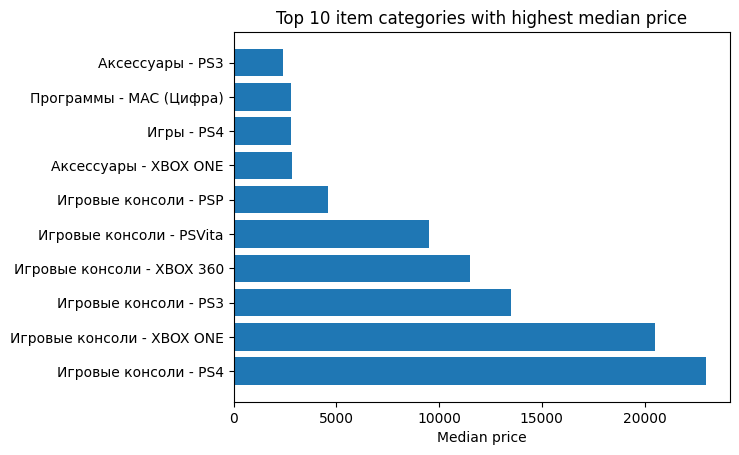

In [125]:
fig, ax = plt.subplots()
ax.barh(cat_highest_medprice['item_category_name'], cat_highest_medprice['item_price'])

ax.set_xlabel('Median price')
ax.set_title('Top 10 item categories with highest median price')
plt.show()

In [126]:
# Top 10 item categories with the most quantity sold
cat_most_sold = sales_full[['item_category_id', 'item_category_name', 'item_cnt_day']].copy()
cat_most_sold = cat_most_sold.groupby(['item_category_id', 'item_category_name']).sum()
cat_most_sold = cat_most_sold.sort_values('item_cnt_day', ascending = False).iloc[:10]
cat_most_sold.reset_index(inplace = True)

cat_most_sold

,item_category_id,item_category_name,item_cnt_day
0,40,Кино - DVD,635599.0
1,30,Игры PC - Стандартные издания,458178.0
2,55,Музыка - CD локального производства,349509.0
3,19,Игры - PS3,256627.0
4,37,Кино - Blu-Ray,204778.0
5,71,"Подарки - Сумки, Альбомы, Коврики д/мыши",188034.0
6,28,Игры PC - Дополнительные издания,175500.0
7,23,Игры - XBOX 360,171210.0
8,20,Игры - PS4,128207.0
9,65,Подарки - Настольные игры (компактные),73129.0


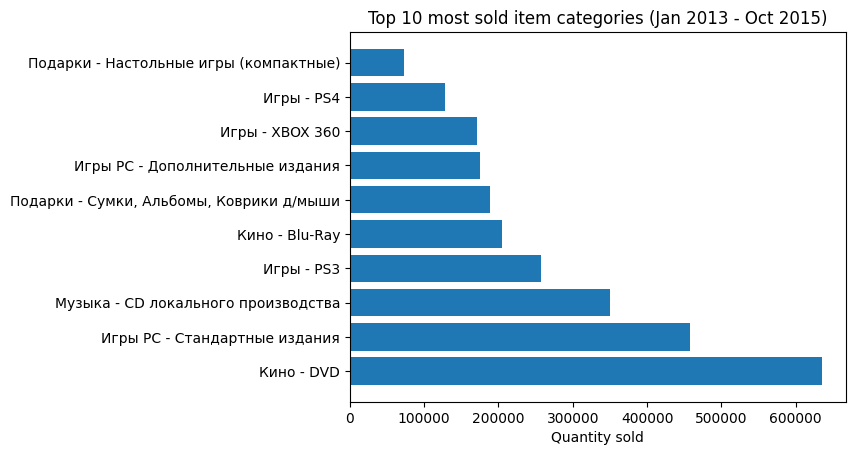

In [127]:
fig, ax = plt.subplots()
ax.barh(cat_most_sold['item_category_name'], cat_most_sold['item_cnt_day'])

ax.set_xlabel('Quantity sold')
ax.set_title('Top 10 most sold item categories (Jan 2013 - Oct 2015)')
plt.show()

In [128]:
# Top 10 shops with the most quantity sold
shop_most_sold = sales_full[['shop_id', 'shop_name', 'item_cnt_day']].copy()
shop_most_sold = shop_most_sold.groupby(['shop_id', 'shop_name']).sum()
shop_most_sold = shop_most_sold.sort_values('item_cnt_day', ascending = False).iloc[:10]
shop_most_sold.reset_index(inplace = True)

shop_most_sold

,shop_id,shop_name,item_cnt_day
0,31,"Москва ТЦ ""Семеновский""",311683.0
1,25,"Москва ТРК ""Атриум""",242554.0
2,54,"Химки ТЦ ""Мега""",186508.0
3,28,"Москва ТЦ ""МЕГА Теплый Стан"" II",184997.0
4,42,"СПб ТК ""Невский Центр""",145456.0
5,57,"Якутск Орджоникидзе, 56",141741.0
6,27,"Москва ТЦ ""МЕГА Белая Дача II""",136973.0
7,6,"Воронеж (Плехановская, 13)",101025.0
8,58,"Якутск ТЦ ""Центральный""",82082.0
9,46,"Сергиев Посад ТЦ ""7Я""",79194.0


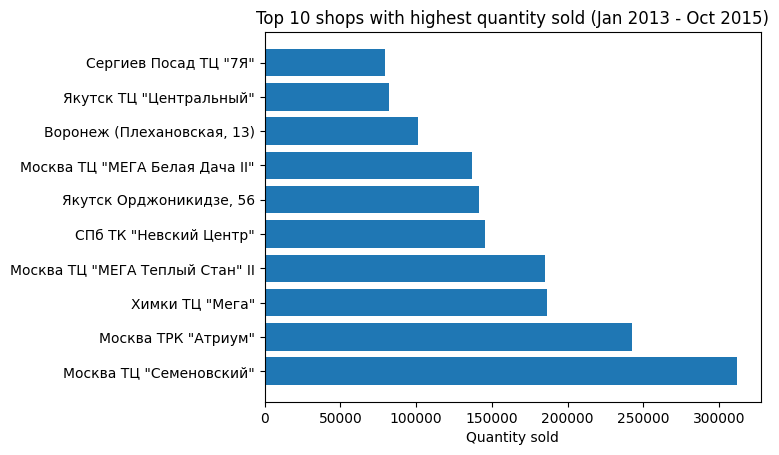

In [129]:
fig, ax = plt.subplots()
ax.barh(shop_most_sold['shop_name'], shop_most_sold['item_cnt_day'])

ax.set_xlabel('Quantity sold')
ax.set_title('Top 10 shops with highest quantity sold (Jan 2013 - Oct 2015)')
plt.show()

In [130]:
# Get unique (shop_id, item_id) pairs
shop_item_unique = sales_full[['shop_id', 'shop_name', 'item_id']].copy()
shop_item_unique.drop_duplicates(inplace = True)

# Top 10 shops selling the most unique items
shops_and_items = shop_item_unique.groupby(['shop_id', 'shop_name'], as_index = False).count()
shops_and_items.sort_values('item_id', ascending = False, inplace = True)
shops_and_items = shops_and_items.iloc[:10]
shops_and_items

,shop_id,shop_name,item_id
25,25,"Москва ТРК ""Атриум""",15367
31,31,"Москва ТЦ ""Семеновский""",14416
54,54,"Химки ТЦ ""Мега""",13863
28,28,"Москва ТЦ ""МЕГА Теплый Стан"" II",12572
57,57,"Якутск Орджоникидзе, 56",12281
42,42,"СПб ТК ""Невский Центр""",12034
6,6,"Воронеж (Плехановская, 13)",11856
56,56,"Чехов ТРЦ ""Карнавал""",11049
27,27,"Москва ТЦ ""МЕГА Белая Дача II""",10842
21,21,"Москва МТРЦ ""Афи Молл""",10145


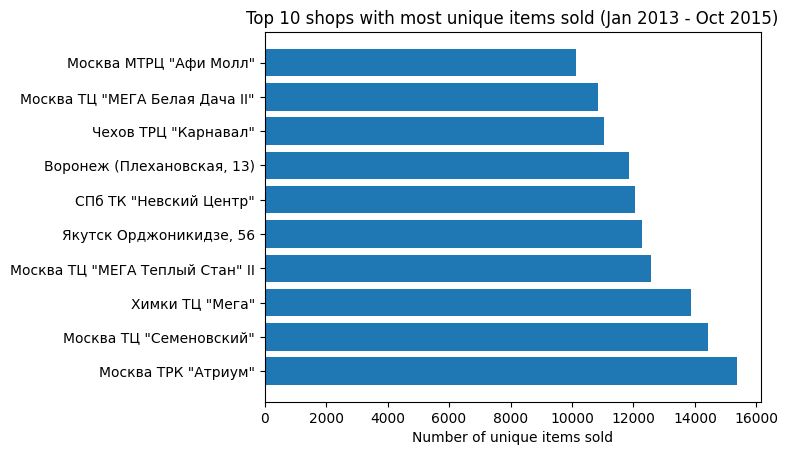

In [131]:
fig, ax = plt.subplots()
ax.barh(shops_and_items['shop_name'], shops_and_items['item_id'])

ax.set_xlabel('Number of unique items sold')
ax.set_title('Top 10 shops with most unique items sold (Jan 2013 - Oct 2015)')
plt.show()

In [132]:
# Number of unique items vs. number of shops sold them
shop_item_unique_2 = sales_full[['item_id', 'item_name', 'shop_id']].copy()
shop_item_unique_2.drop_duplicates(inplace = True)

shop_item_unique_2 = shop_item_unique_2.groupby(['item_id', 'item_name'], as_index = False).count()
shop_item_unique_2.sort_values('shop_id', ascending = False, inplace = True)
shop_item_unique_2.rename(columns = {'shop_id': 'shop_count'}, inplace = True)
shop_item_unique_2.head()

,item_id,item_name,shop_count
2749,2808,"Diablo III [PC, Jewel, русская версия]",58
3014,3076,EA SPORTS MMA [PS3],58
2263,2308,"Call of Duty: Black Ops II [PС, Jewel, русская...",58
5717,5822,Playstation Store пополнение бумажника: Карта ...,58
2694,2753,"Dead Space 3 [PC, русские субтитры]",57


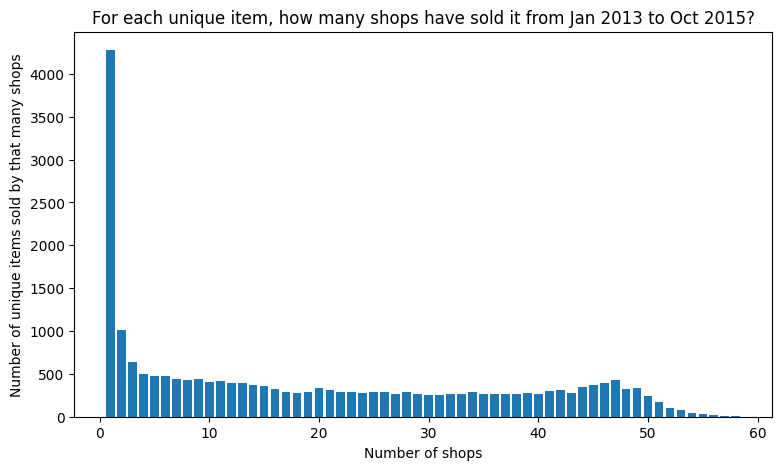

In [133]:
# These are discrete values, so a histogram isn't the most suitable for this type of chart
shop_count_items = pd.DataFrame(shop_item_unique_2[['shop_count']].value_counts())
shop_count_items.reset_index(inplace = True)
shop_count_items.head()

fig, ax = plt.subplots(figsize = (9, 5))
ax.bar(shop_count_items['shop_count'], shop_count_items['count'])

ax.set_xlabel('Number of shops')
ax.set_ylabel('Number of unique items sold by that many shops')
ax.set_title('For each unique item, how many shops have sold it from Jan 2013 to Oct 2015?')
plt.show()

In [134]:
# Which are the biggest sales in amount made by a (shop_id, item_id) pair?
biggest_sales = sales_full[['date', 'shop_id', 'item_id', 'shop_name', 'item_name', 'item_cnt_day']].copy() # keep the necessary columns only
biggest_sales.sort_values('item_cnt_day', ascending = False, inplace = True)
biggest_sales = biggest_sales.iloc[:10]
biggest_sales

,date,shop_id,item_id,shop_name,item_name,item_cnt_day
2909818,2015-10-28,12,11373,Интернет-магазин ЧС,Доставка до пункта выдачи (Boxberry),2169.0
2326930,2015-01-15,12,20949,Интернет-магазин ЧС,Фирменный пакет майка 1С Интерес белый (34*42)...,1000.0
2864235,2015-09-30,12,9248,Интернет-магазин ЧС,"Билет ""ИгроМир 2015"" - 3 октября 2015 (сайт) [...",669.0
2851091,2015-09-30,55,9249,Цифровой склад 1С-Онлайн,"Билет ""ИгроМир 2015"" - 3 октября 2015 (сайт) У...",637.0
2608040,2015-04-14,12,3731,Интернет-магазин ЧС,"Grand Theft Auto V [PC, русские субтитры]",624.0
2626181,2015-05-19,12,11373,Интернет-магазин ЧС,Доставка до пункта выдачи (Boxberry),539.0
2851073,2015-09-29,55,9249,Цифровой склад 1С-Онлайн,"Билет ""ИгроМир 2015"" - 3 октября 2015 (сайт) У...",533.0
2048518,2014-10-02,12,9242,Интернет-магазин ЧС,"Билет ""ИгроМир 2014"" (на один день (отдельно -...",512.0
2067669,2014-10-09,55,19437,Цифровой склад 1С-Онлайн,"Средиземье: Тени Мордора [PC, Цифровая версия]",508.0
2864260,2015-09-29,12,9248,Интернет-магазин ЧС,"Билет ""ИгроМир 2015"" - 3 октября 2015 (сайт) [...",504.0


All the top 10 largest transactions are made in either one of two shops, ```Интернет-магазин ЧС``` (Online Store CHS) and ```Цифровой склад 1С-Онлайн``` (Digital Warehouse 1C-Online).

_Note: I don't know Russian, so all the translations are made with Google Translate._

### V. Adding the time series element

In [135]:
# https://blog.finxter.com/5-effective-ways-to-check-missing-dates-in-pandas/
# https://stackoverflow.com/questions/18176933/create-an-empty-data-frame-with-index-from-another-data-frame

# What date is missing?
# Extract only the dates in the data of sales recorded (sales_dates)
sales_dates = sales_full[['date']].copy()
sales_dates.drop_duplicates(inplace = True)

# Create a DataFrame containing all possible dates within the "min sale date" and "max sale date" (full_dates)
dates_indexer = pd.date_range(start = min(sales_dates['date']), end = max(sales_dates['date'])) # returns a DateTime index
full_dates = pd.DataFrame(index = dates_indexer)
full_dates.reset_index(inplace = True) # for better merging

# Now join full_dates with sales_dates to check if there is any NaT values
check_dates = full_dates.merge(sales_dates, left_on = 'index', right_on = 'date', how = 'left')
check_dates.head()

,index,date
0,2013-01-01,2013-01-01
1,2013-01-02,2013-01-02
2,2013-01-03,2013-01-03
3,2013-01-04,2013-01-04
4,2013-01-05,2013-01-05


In [136]:
check_dates.isna().sum()

index    0
date     0
dtype: int64

All possible dates between the "min sale date" and "max sale date" has a record in the sales dataset.

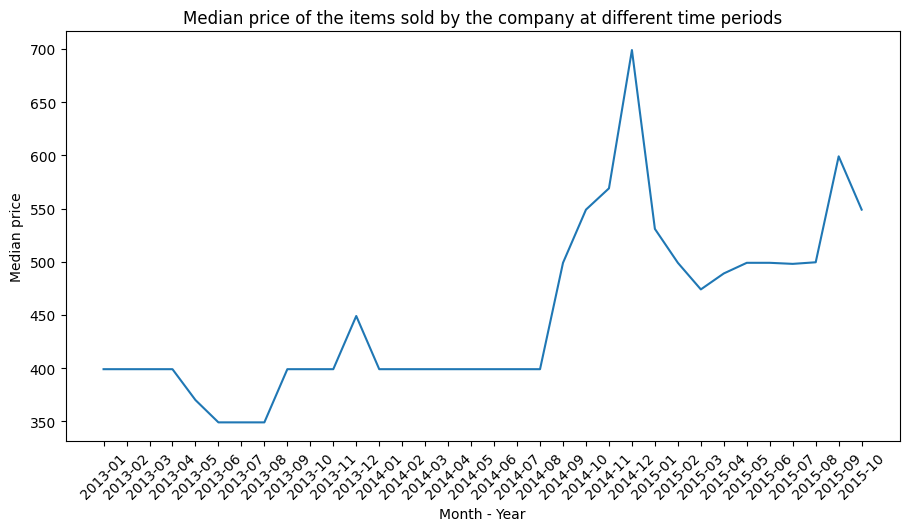

In [137]:
# Median price over time
price_over_my = sales_full[['month_year', 'item_price']].copy()
price_over_my = price_over_my.groupby('month_year').median()
price_over_my.reset_index(inplace = True)

fig, ax = plt.subplots(figsize = (9, 5))
ax.plot(price_over_my['month_year'], price_over_my['item_price'])
ax.tick_params(axis = 'x', labelrotation = 45)
plt.tight_layout()

ax.set_xlabel('Month - Year')
ax.set_ylabel('Median price')
ax.set_title('Median price of the items sold by the company at different time periods')
plt.show()

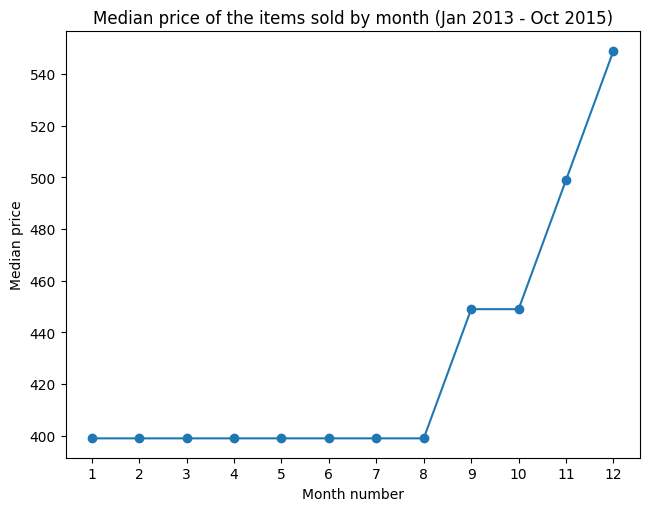

In [138]:
# Median price over months of the year
price_over_my = sales_full[['month', 'item_price']].copy()
price_over_my = price_over_my.groupby('month').median()
price_over_my.reset_index(inplace = True)

fig, ax = plt.subplots()
ax.plot(price_over_my['month'], price_over_my['item_price'], marker = 'o')
plt.tight_layout()

ax.set_xticks(range(1, 13, 1))
ax.set_xlabel('Month number')
ax.set_ylabel('Median price')
ax.set_title('Median price of the items sold by month (Jan 2013 - Oct 2015)')
plt.show()

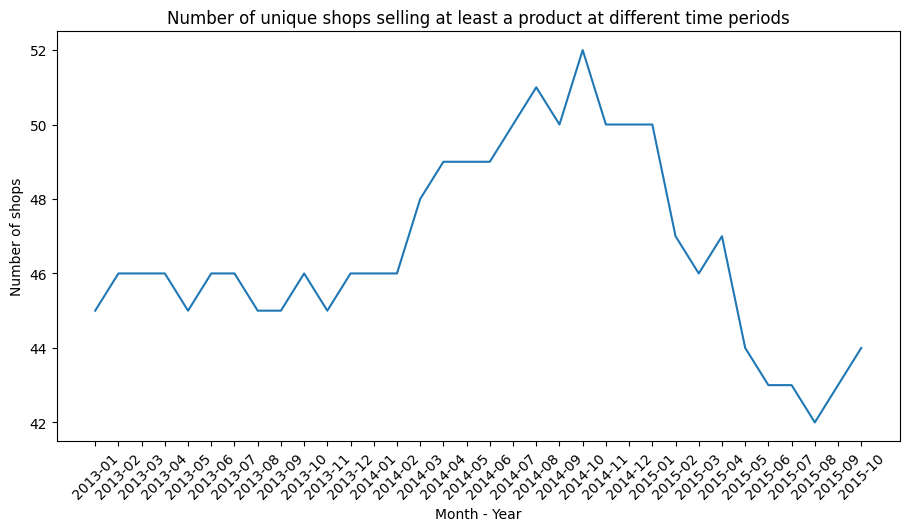

In [139]:
# Count number of distinct shops by month-year pair
shop_count_my = sales_full[['month_year', 'shop_id']].groupby('month_year').nunique()
# .nunique() to denote that we only care about the number of distinct shops
shop_count_my = shop_count_my.reset_index()
# Move the month-year outside the index for more convenient plotting

fig, ax = plt.subplots(figsize = (9, 5))
ax.plot(shop_count_my['month_year'], shop_count_my['shop_id'])
ax.tick_params(axis = 'x', labelrotation = 45)
plt.tight_layout()

ax.set_xlabel('Month - Year')
ax.set_ylabel('Number of shops')
ax.set_title('Number of unique shops selling at least a product at different time periods')
plt.show()

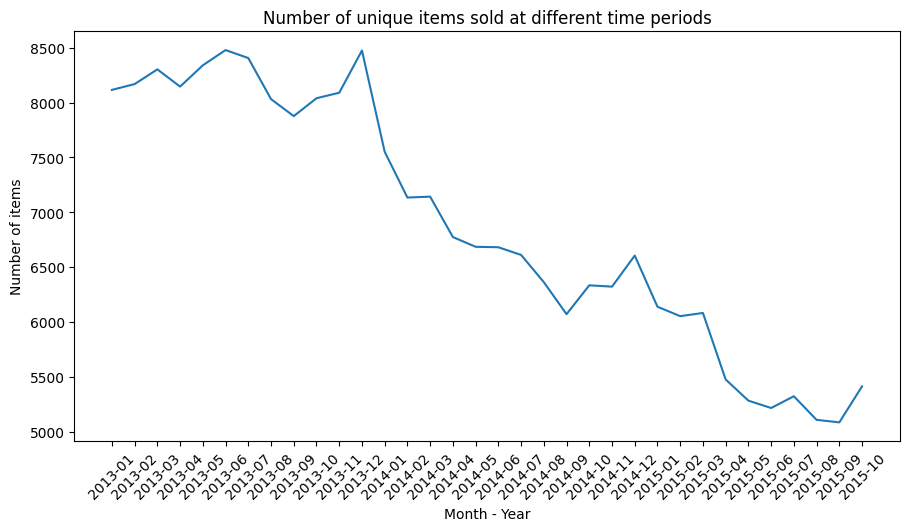

In [140]:
# Count number of distinct shops by month-year pair
item_count_my = sales_full[['month_year', 'item_id']].groupby('month_year').nunique()
# .nunique() to denote that we only care about the number of distinct shops
item_count_my = item_count_my.reset_index()
# Move the month-year outside the index for more convenient plotting

fig, ax = plt.subplots(figsize = (9, 5))
ax.plot(item_count_my['month_year'], item_count_my['item_id'])
ax.tick_params(axis = 'x', labelrotation = 45)
plt.tight_layout()

ax.set_xlabel('Month - Year')
ax.set_ylabel('Number of items')
ax.set_title('Number of unique items sold at different time periods')
plt.show()

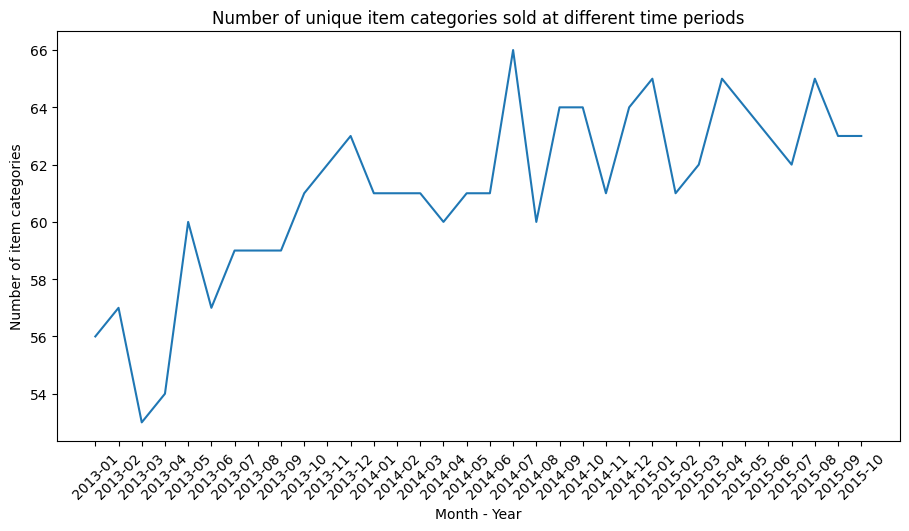

In [141]:
# Count number of distinct shops by month-year pair
category_count_my = sales_full[['month_year', 'item_category_id']].groupby('month_year').nunique()
# .nunique() to denote that we only care about the number of distinct shops
category_count_my = category_count_my.reset_index()
# Move the month-year outside the index for more convenient plotting

fig, ax = plt.subplots(figsize = (9, 5))
ax.plot(category_count_my['month_year'], category_count_my['item_category_id'])
ax.tick_params(axis = 'x', labelrotation = 45)
plt.tight_layout()

ax.set_xlabel('Month - Year')
ax.set_ylabel('Number of item categories')
ax.set_title('Number of unique item categories sold at different time periods')
plt.show()

### VI. More complicated analysis with grouping time series:

In [142]:
# Number of unique items and shops that the company has sold
print(f'Number of unique items: {sales_full['item_id'].nunique()}')
print(f'Number of unique shops: {sales_full['shop_id'].nunique()}')

Number of unique items: 21807
Number of unique shops: 60


In [143]:
sales_datetime = sales_full[['date', 'date_block_num', 'month_year', 'shop_id', 'item_id', 'item_price', 'item_cnt_day']].copy()
sales_datetime.sort_values(['date', 'shop_id', 'item_id'], inplace = True, ignore_index = True)
sales_datetime.head()

,date,date_block_num,month_year,shop_id,item_id,item_price,item_cnt_day
0,2013-01-01,0,2013-01,2,991,99.0,1.0
1,2013-01-01,0,2013-01,2,1472,2599.0,1.0
2,2013-01-01,0,2013-01,2,1905,249.0,1.0
3,2013-01-01,0,2013-01,2,2920,599.0,2.0
4,2013-01-01,0,2013-01,2,3320,1999.0,1.0


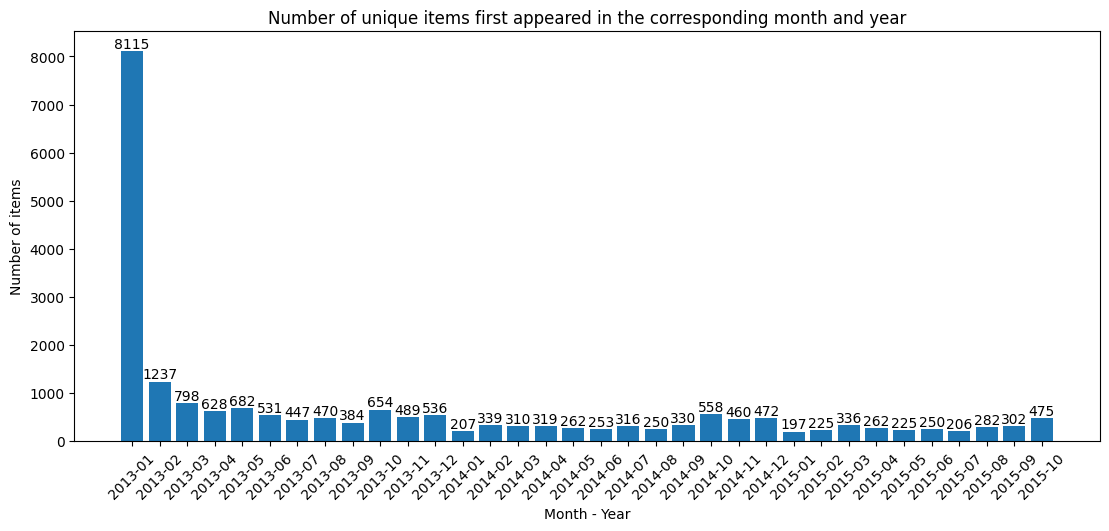

In [144]:
# First appearance of each item_id in the data?
first_item_appearance = sales_datetime.drop_duplicates(subset = ['item_id'], ignore_index = True)
first_item_appearance = first_item_appearance[['month_year', 'item_id']].groupby('month_year', as_index = False).count()

fig, ax = plt.subplots(figsize = (11, 5))
# Make a bar plot with number labels for better readability
ax.bar_label(ax.bar(first_item_appearance['month_year'], first_item_appearance['item_id']))
ax.tick_params(axis = 'x', labelrotation = 45)
plt.tight_layout()

ax.set_xlabel('Month - Year')
ax.set_ylabel('Number of items')
ax.set_title('Number of unique items first appeared in the corresponding month and year')
plt.show()

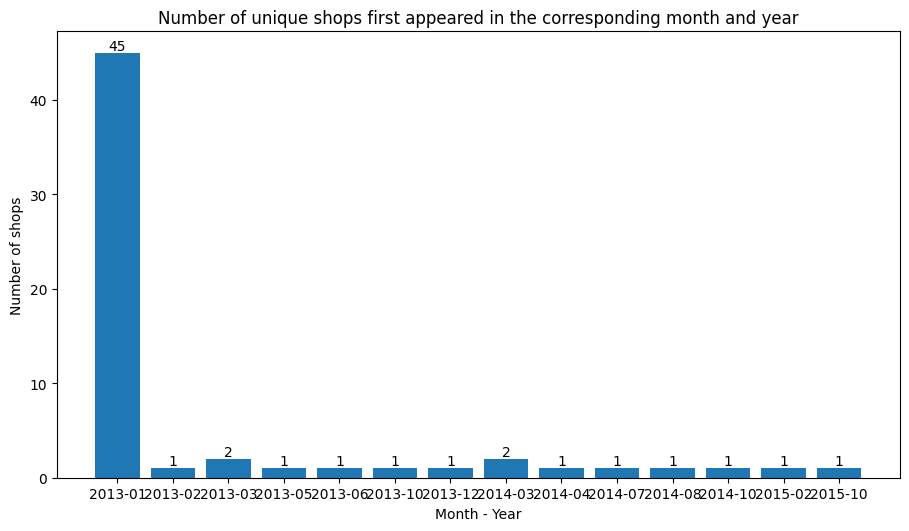

In [145]:
# First appearance of each shop_id in the data?
first_item_appearance = sales_datetime.drop_duplicates(subset = ['shop_id'], ignore_index = True)
first_item_appearance = first_item_appearance[['month_year', 'shop_id']].groupby('month_year', as_index = False).count()

fig, ax = plt.subplots(figsize = (9, 5))
ax.bar_label(ax.bar(first_item_appearance['month_year'], first_item_appearance['shop_id']))
plt.tight_layout()

ax.set_xlabel('Month - Year')
ax.set_ylabel('Number of shops')
ax.set_title('Number of unique shops first appeared in the corresponding month and year')
plt.show()

Notice that the x-axis does not cover all months from ```2013-01``` to ```2015-10```!

#### Running and moving metrics:

In [155]:
sales_dategroup = sales_datetime[['date', 'item_cnt_day']].copy()
sales_dategroup = sales_dategroup.groupby('date').sum()

# Moving total of items sold in the last 7 days and 30 days in all shops

sales_dategroup['moving_total_7d'] = sales_dategroup['item_cnt_day'].rolling(window = 7).sum()
sales_dategroup['moving_average_7d'] = sales_dategroup['item_cnt_day'].rolling(window = 7).mean()

sales_dategroup['moving_total_30d'] = sales_dategroup['item_cnt_day'].rolling(window = 30).sum()
sales_dategroup['moving_average_30d'] = sales_dategroup['item_cnt_day'].rolling(window = 30).mean()

# Cumulative sum of items sold in all shops
sales_dategroup['cumulative_sum'] = sales_dategroup['item_cnt_day'].cumsum()

sales_dategroup.reset_index(inplace = True)
sales_dategroup.head(10)

,date,item_cnt_day,moving_total_7d,moving_average_7d,moving_total_30d,moving_average_30d,cumulative_sum
0,2013-01-01,1963.0,NaN,NaN,NaN,NaN,1963.0
1,2013-01-02,8266.0,NaN,NaN,NaN,NaN,10229.0
2,2013-01-03,7466.0,NaN,NaN,NaN,NaN,17695.0
3,2013-01-04,6639.0,NaN,NaN,NaN,NaN,24334.0
4,2013-01-05,6374.0,NaN,NaN,NaN,NaN,30708.0
5,2013-01-06,5880.0,NaN,NaN,NaN,NaN,36588.0
6,2013-01-07,5016.0,41604.0,5943.428571,NaN,NaN,41604.0
7,2013-01-08,4818.0,44459.0,6351.285714,NaN,NaN,46422.0
8,2013-01-09,3186.0,39379.0,5625.571429,NaN,NaN,49608.0
9,2013-01-10,3184.0,35097.0,5013.857143,NaN,NaN,52792.0


In [150]:
sales_dategroup['date'].dtype

dtype('<M8[ns]')

In [60]:
# Check if there is any date gap
date_range = pd.date_range(start = sales_dategroup['date'].min(), end = sales_dategroup['date'].max()).tolist()
print(f'Number of dates if there is no date gap: {len(date_range)}')
print(f'Number of dates mentioned in the dataset: {len(sales_dategroup['date'])}')

Number of dates if there is no date gap: 1034
Number of dates mentioned in the dataset: 1034


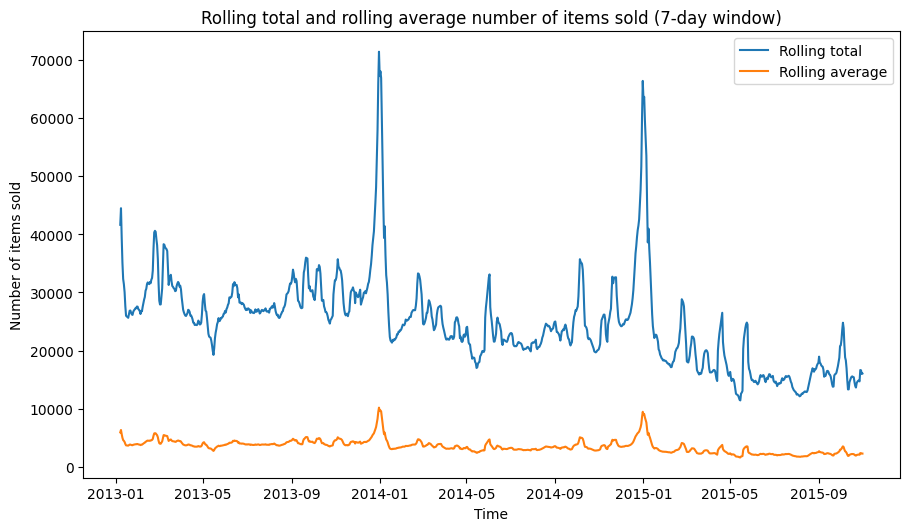

In [61]:
fig, ax = plt.subplots(figsize = (9, 5))
ax.plot(sales_dategroup['date'], sales_dategroup['moving_total_7d'])
ax.plot(sales_dategroup['date'], sales_dategroup['moving_average_7d'])

plt.tight_layout()

ax.legend(['Rolling total', 'Rolling average'])
ax.set_xlabel('Time')
ax.set_ylabel('Number of items sold')
ax.set_title('Rolling total and rolling average number of items sold (7-day window)')
plt.show()

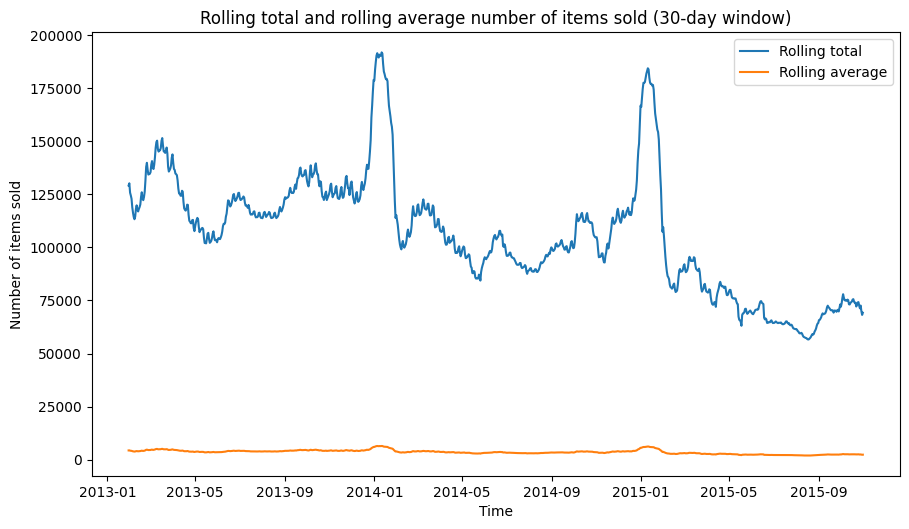

In [62]:
fig, ax = plt.subplots(figsize = (9, 5))
ax.plot(sales_dategroup['date'], sales_dategroup['moving_total_30d'])
ax.plot(sales_dategroup['date'], sales_dategroup['moving_average_30d'])

plt.tight_layout()

ax.legend(['Rolling total', 'Rolling average'])
ax.set_xlabel('Time')
ax.set_ylabel('Number of items sold')
ax.set_title('Rolling total and rolling average number of items sold (30-day window)')
plt.show()

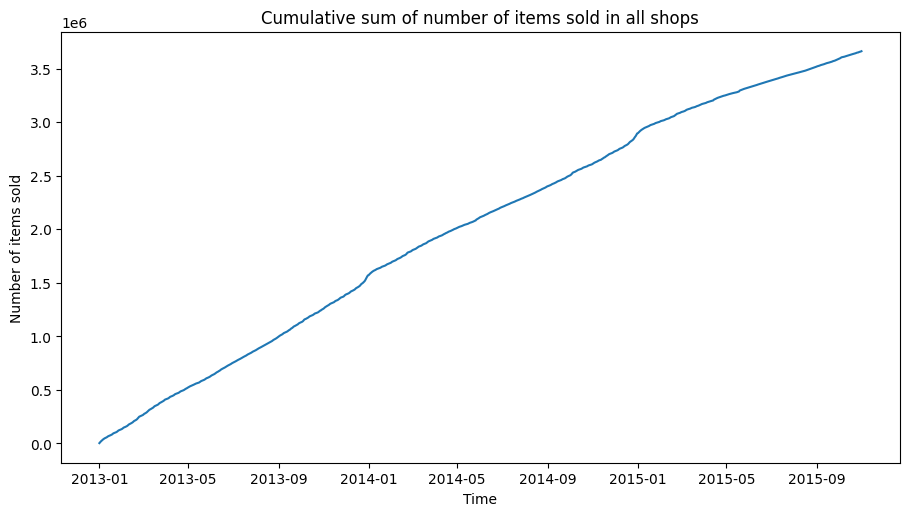

In [63]:
fig, ax = plt.subplots(figsize = (9, 5))
ax.plot(sales_dategroup['date'], sales_dategroup['cumulative_sum'])

plt.tight_layout()

ax.set_xlabel('Time')
ax.set_ylabel('Number of items sold')
ax.set_title('Cumulative sum of number of items sold in all shops')
plt.show()

#### Lagged metrics:

In [166]:
sales_dategroup_2 = sales_datetime[['date', 'item_cnt_day']].copy()
sales_dategroup_2 = sales_dategroup_2.groupby('date').sum()

sales_dategroup_2['lag_1'] = sales_dategroup_2['item_cnt_day'].shift(periods = 1) # lagged 1 day
sales_dategroup_2['lag_7'] = sales_dategroup_2['item_cnt_day'].shift(periods = 7) # lagged 7 days (= 1 week)
sales_dategroup_2['lag_30'] = sales_dategroup_2['item_cnt_day'].shift(periods = 30) # lagged 30 days (~ 1 month)
sales_dategroup_2['lag_90'] = sales_dategroup_2['item_cnt_day'].shift(periods = 90) # lagged 90 days (~ 3 months)

sales_dategroup_2.head(10)

,item_cnt_day,lag_1,lag_7,lag_30,lag_90
date,,,,,
2013-01-01,1963.0,NaN,NaN,NaN,NaN
2013-01-02,8266.0,1963.0,NaN,NaN,NaN
2013-01-03,7466.0,8266.0,NaN,NaN,NaN
2013-01-04,6639.0,7466.0,NaN,NaN,NaN
2013-01-05,6374.0,6639.0,NaN,NaN,NaN
2013-01-06,5880.0,6374.0,NaN,NaN,NaN
2013-01-07,5016.0,5880.0,NaN,NaN,NaN
2013-01-08,4818.0,5016.0,1963.0,NaN,NaN
2013-01-09,3186.0,4818.0,8266.0,NaN,NaN


In [167]:
sales_dategroup_2.corr()

,item_cnt_day,lag_1,lag_7,lag_30,lag_90
item_cnt_day,1.000000,0.679732,0.646126,0.098540,0.252327
lag_1,0.679732,1.000000,0.492721,0.284299,0.079318
lag_7,0.646126,0.492721,1.000000,0.098703,0.273227
lag_30,0.098540,0.284299,0.098703,1.000000,0.011617
lag_90,0.252327,0.079318,0.273227,0.011617,1.000000


Text(0.5, 1.0, 'Correlation between lagged features of the number of items sold in all shops in a day')

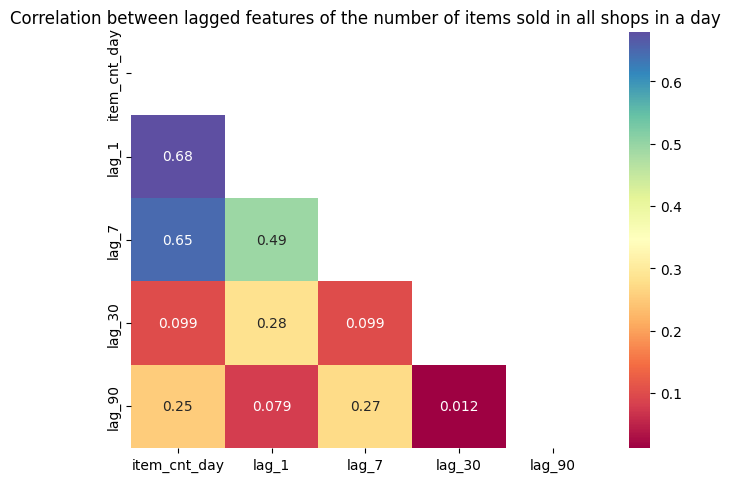

In [171]:
plt.figure()
sns.heatmap(data = sales_dategroup_2.corr(), mask = np.triu(sales_dategroup_2.corr()), cmap = 'Spectral', annot = True)
# Used np.triu to show only the lower triangle of the correlation graph

plt.tight_layout()
plt.title('Correlation between lagged features of the number of items sold in all shops in a day')

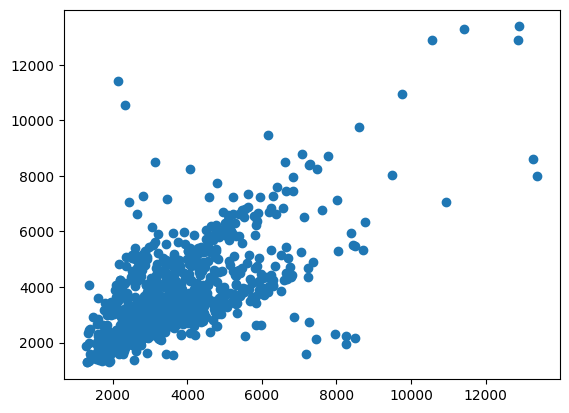

In [172]:
# Lag plot for 1 day
fig, ax = plt.subplots()
ax.scatter(sales_dategroup_2['item_cnt_day'], sales_dategroup_2['lag_1'])